# 分类：简单的数字识别（二）
### Classification: Simple Handwritten Digit Recognition Ⅱ

上一篇讲到简单的二分类器及其性能评价，本篇就来探讨下多类别的分类问题。

## 1 加载数据
Load the Data：using sklearn's handwritten digit datasets

In [1]:
from sklearn import datasets
digits=datasets.load_digits()

## 2 查看数据
Take a Quick Look at the Data

In [2]:
X=digits.data
y=digits.target
print(X.shape)

(1797, 64)


In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## 3 准备训练集和测试集
Prepare the Training Set and the Test Set

In [4]:
test_ratio=0.2
test_size=int(len(X)*test_ratio)

In [5]:
X_test,X_train=X[:test_size],X[test_size:]
y_test,y_train=y[:test_size],y[test_size:]

In [6]:
import numpy as np
np.random.seed(50)

shuffle_index=np.random.permutation(len(X)-test_size)

In [7]:
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

## 4 多类别分类
Multiclass Classification

用二分类器去执行多类别分类，总的来说有两种策略，以数字识别来说：

1）“一对所有”（OvA）策略
    
    训练10个二分类器，每个分类器对应一个数字。当对某张图片进行分类时，让每个分类器对其进行分类，选出决策分数最高的那个分类器。
    
2）“一对一”（OvO）策略

    对每一对数字训练一个二分类器，共需训练45个分类器。当对某张图片进行分类时，让每个分类器对其进行分类。

首先来回顾一下上一篇：我们首先把target处理成“是1”和“非1”两种类别，然后将它与X一起放入SGD分类器中；采用decision_function()后，我们得到了一个分数。

In [8]:
y_test_1=(y_test==1)
y_train_1=(y_train==1)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=22)
sgd_clf.fit(X_train,y_train_1)

sample_scores_1=sgd_clf.decision_function([X[1]])

In [11]:
print(sample_scores_1)

[3669.53376365]


这次我们直接把原来的target放进去，看看会怎样？

In [12]:
sgd_clf=SGDClassifier(random_state=22)
sgd_clf.fit(X_train,y_train)

sample_scores=sgd_clf.decision_function([X[1]])

In [13]:
print(sample_scores)

[[-15777.7684099    3669.53376365  -7103.65522803  -3321.81748887
   -2848.54424899  -8534.06605441  -8368.87792168  -9822.23091297
   -7441.48985801  -9460.87508879]]


In [14]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
np.argmax(sample_scores)

1

得到的是一个10维的向量，也就是说针对每个类别都进行了打分。同时也可以观察到第二个值是最大的，而输进去的样本正好是1的数据。

    np.argmax()获得一/多维矩阵最大值的位置，通过axis=0/1/2参数进行控制对比的方向。
    classes_属性访问分类器划分的类别
    
sklearn也提供了上述两种策略的使用方式：OneVsOneClassifier类，OneVsRestClassifier类。

    可以将一个二分类器传递给它。

In [16]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(sgd_clf)
ovo_clf.fit(X_train,y_train)
ovo_clf.predict(X[0:20])

array([0, 1, 1, 3, 4, 9, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 3])

In [17]:
len(ovo_clf.estimators_)

45

我们知道前20个就是0~9循环嘛，这里预测还错挺多的。二分类器的数量就像我们上面说的是45个。

随机森林分类器本身就可以直接将一个样本分到多个类别。

In [18]:
from sklearn.ensemble import RandomForestClassifier
ranfor_clf=RandomForestClassifier(n_estimators=10,random_state=22)
ranfor_clf.fit(X_train,y_train)
ranfor_clf.predict(X[0:20])

array([0, 1, 8, 3, 4, 3, 6, 7, 8, 9, 0, 1, 1, 3, 4, 5, 6, 7, 8, 1])

In [19]:
ranfor_clf.predict_proba(X[0:5])

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.3, 0.1, 0. , 0. , 0. , 0. , 0. , 0.6, 0. ],
       [0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. , 0.1],
       [0.2, 0. , 0. , 0. , 0.5, 0. , 0.1, 0. , 0.2, 0. ]])

来看看随机森林对前面5个样本都进行了怎样的判断。我们知道第三个应该是2，对应的概率显示，这个分类器认为这个样本有30%的可能是1,10%的可能是2,60%的可能是8。

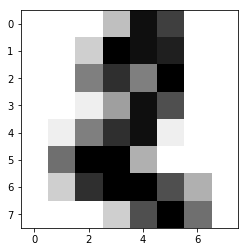

In [20]:
plt.imshow(X[2].reshape(8,8),cmap = mpl.cm.binary,interpolation="nearest")

确实是个令人尴尬的样本。

## 5 性能评价
Performance measures

1）交叉验证

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.89834025, 0.93125   , 0.92857143])

In [22]:
cross_val_score(ovo_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.94813278, 0.95      , 0.93067227])

In [23]:
cross_val_score(ranfor_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.93775934, 0.94375   , 0.93907563])

2）混淆矩阵

因为改进算法的关键在于明确算法误差的来源，我们可以利用混淆矩阵来得到一个直观的洞察。

In [24]:
from sklearn.model_selection import cross_val_predict
y_train_predict=cross_val_predict(ranfor_clf,X_train,y_train,cv=3)

from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y_train,y_train_predict)

In [25]:
conf_matrix

array([[137,   0,   0,   0,   3,   0,   0,   0,   0,   0],
       [  0, 141,   0,   0,   0,   0,   0,   0,   2,   1],
       [  0,   3, 136,   1,   0,   0,   0,   0,   0,   1],
       [  1,   3,   0, 128,   0,   0,   1,   4,   3,   5],
       [  1,   1,   0,   0, 141,   1,   0,   3,   0,   0],
       [  1,   1,   0,   0,   1, 140,   0,   0,   1,   2],
       [  1,   2,   0,   1,   0,   0, 140,   0,   1,   0],
       [  0,   0,   0,   0,   1,   2,   0, 140,   1,   0],
       [  0,   6,   2,   3,   2,   1,   0,   2, 121,   3],
       [  1,   3,   0,   1,   1,   3,   0,   4,   5, 128]], dtype=int64)

数据主要聚集在对角线上，说明分类正确的比较多，我们试试用matshow()以及刚才画图用的inshow()来画一下这个混淆矩阵。

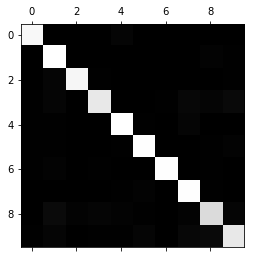

In [26]:
plt.matshow(conf_matrix,cmap=plt.cm.gray)

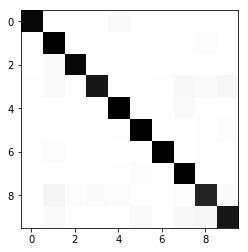

In [27]:
plt.imshow(conf_matrix,cmap = mpl.cm.binary,interpolation="nearest")

由第一个图可见，对角线的值越大颜色越白，3、8、9这三个数字的识别表现似乎不如其他数字，抑或数据集中这些数字本来就比较少。

通过第二个图，我们把数字间混淆的类型显示了出来。

In [28]:
import pandas as pd
pd.DataFrame(y_train)[0].value_counts().sort_index()

0    140
1    144
2    141
3    145
4    147
5    146
6    145
7    144
8    140
9    146
Name: 0, dtype: int64

可见样本中8确实少了一点，但是9是很多的。

而且我们可以观察到混淆矩阵每一行加起来就是每种类别的样本数，可想而知每一行代表了该类样本在进行分类时得到的分类结果分布。

第二个图的呈现想过还是不太好。因为最大值和最小值差距太大了，让我们把对角线的数值去掉,且把错误个数用更为可比较的错误率来作为指标。

In [29]:
numbers=conf_matrix.sum(axis=1)
numbers.shape

(10,)

In [30]:
numbers2=conf_matrix.sum(axis=1,keepdims=True)
numbers2.shape

(10, 1)

keepdims参数的作用就是保持原来的维度，如果不设置会导致混淆矩阵的归一化出现错误。

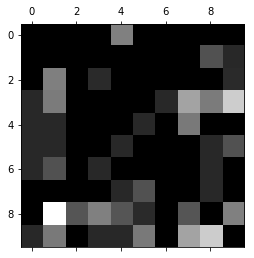

In [31]:
norm_conf_matrix=conf_matrix/numbers2
np.fill_diagonal(norm_conf_matrix,0)
plt.matshow(norm_conf_matrix,cmap=plt.cm.gray)

总体，数字1、2的分类表现相对较好，8、9表现比较差；8、9常被识别为别的数字，别的数字也常被识别为8、9。

细观，8经常被判定为1,3经常被判定为9,9经常被判定为8。

In [32]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 8
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

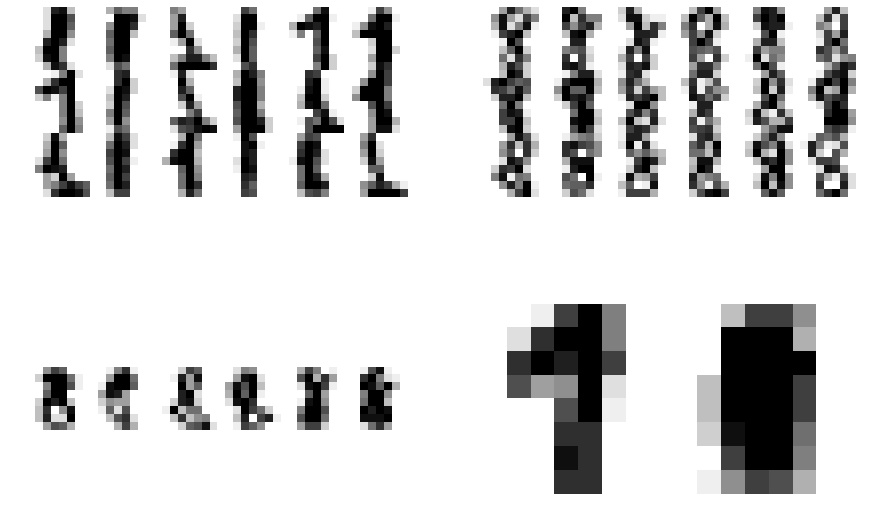

In [33]:
cl_1,cl_8=1,8
X_11=X_train[(y_train==cl_1)&(y_train_predict==cl_1)]
X_18=X_train[(y_train==cl_1)&(y_train_predict==cl_8)]
X_81=X_train[(y_train==cl_8)&(y_train_predict==cl_1)]
X_88=X_train[(y_train==cl_8)&(y_train_predict==cl_8)]

plt.figure(figsize=(15,10))
plt.subplot(221);plot_digits(X_11[:18], images_per_row=6)
plt.subplot(222);plot_digits(X_88[:18], images_per_row=6)
plt.subplot(223);plot_digits(X_81[:18], images_per_row=6)
plt.subplot(224);plot_digits(X_18[:18], images_per_row=6)